<a href="https://www.kaggle.com/code/gcuber/semantic-segmentation-with-u-net-from-scratch?scriptVersionId=179532466" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install torchmetrics
!pip install albumentations
!piip install segmentation_models_pytorch

/bin/bash: piip: command not found


In [3]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2024-05-24 08:25:27--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2024-05-24 08:25:27--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: 'images.tar.gz'

images.tar.gz       100%[===================>] 755.23M  20.1MB/s    in 39s     

2024-05-24 08:26:07 (19.4 MB/s) - 'images.tar.gz' saved [791918971/791918971]

--2024-05-24 08:26:08--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [4]:
!tar -xf annotations.tar.gz
!tar -xf images.tar.gz

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from glob import glob

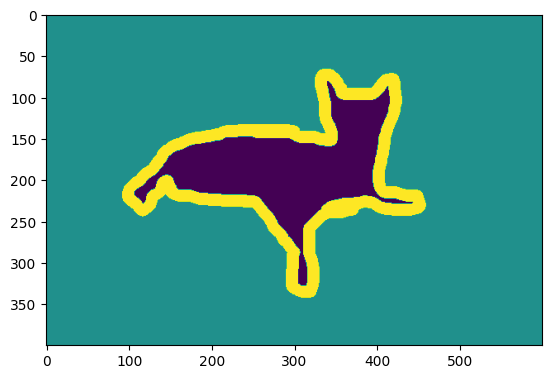

In [6]:
mask_path = '/kaggle/working/annotations/trimaps/Abyssinian_1.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

(400, 600, 3)


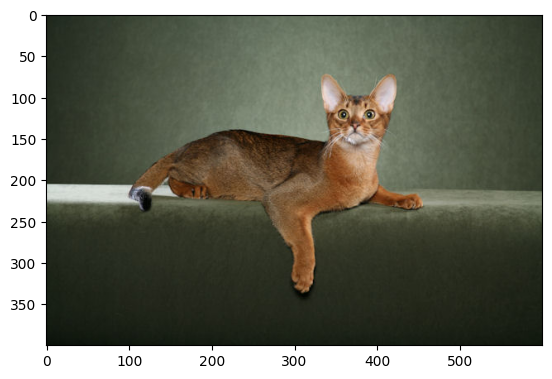

In [7]:
image_path = '/kaggle/working/images/Abyssinian_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

In [8]:
class DogCatDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.txt_file = txt_file
        self.transform = transform
        self.img_path_lst = []
        with open(self.txt_file) as file_in:
            for line in file_in:
                self.img_path_lst.append(line.split(" ")[0])
                
    def __len__(self):
        return len(self.img_path_lst)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, "images", "{}.jpg".format(self.img_path_lst[idx]))
        mask_path = os.path.join(self.root_dir, "annotations", "trimaps", "{}.png".format(self.img_path_lst[idx]))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # zero indexing
        # foreground -> 1
        # background 2 -> 0
        # 3 -> 1
        mask[mask==2] = 0
        mask[mask==3] = 1
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
                                           
        return image, mask

In [9]:
trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.CoarseDropout(max_holes=5, max_height=25, max_width=25, min_holes=1, min_height=10, min_width=10, fill_value=0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
      
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

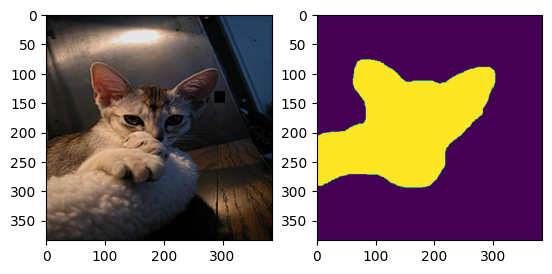

In [11]:
train_dataset  = DogCatDataset("/kaggle/working", "/kaggle/working/annotations/trainval.txt",train_transform )
test_dataset = DogCatDataset("/kaggle/working", "/kaggle/working/annotations/test.txt", test_transform)
image, mask = train_dataset.__getitem__(10)
#print(image.shape, mask.shape)
#print(mask.unique())
plt.subplot(1,2,1)
plt.imshow(unorm(image).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

## U-net implementation from original paper
paper link: https://arxiv.org/abs/1505.04597
![unet-image.png](https://www.google.com/imgres?q=unet%20architecture&imgurl=https%3A%2F%2Fmiro.medium.com%2Fv2%2Fresize%3Afit%3A1400%2F1*f7YOaE4TWubwaFF7Z1fzNw.png&imgrefurl=https%3A%2F%2Ftowardsdatascience.com%2Funet-line-by-line-explanation-9b191c76baf5&docid=5ls1HPcU2h7_TM&tbnid=32EJywTsHOPPpM&vet=12ahUKEwitr8qB0aWGAxV-sFYBHc2mBOQQM3oECBYQAA..i&w=1400&h=914&hcb=2&ved=2ahUKEwitr8qB0aWGAxV-sFYBHc2mBOQQM3oECBYQAA)

In [12]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, 3,1,1),
    nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, 3,1,1),
    nn.ReLU()
    ) 

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = double_conv(3,64)
        self.block_down2 = double_conv(64, 128)
        self.block_down3 = double_conv(128, 256)
        self.block_down4 = double_conv(256, 512)
        self.block_neck = double_conv(512, 1024)
        self.block_up1 = double_conv(1024+512, 512)
        self.block_up2 = double_conv(256+512, 256)
        self.block_up3 = double_conv(128+256, 128)
        self.block_up4 = double_conv(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)
    
    def forward(self, x):
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)
        
        x = self.block_neck(x)
        
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        
        x = self.conv_cls(x)
        
        return x
    
# model = UNet(1)
# x = torch.rand(4, 3, trainsize, trainsize)
# print(f"Input shape: {x.shape}")
# y = model(x)
# print(f"Output shape: {y.shape}")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count

In [15]:
def accuracy_fn(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat==targets_flat)
    return acc/targets_flat.shape[0]

In [16]:
batch_size = 16

n_workers = os.cpu_count()
print("n_workers = ", n_workers)

trainloader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle=True,
                         num_workers=n_workers)

testloader = DataLoader(test_dataset,
                        batch_size = batch_size,
                        shuffle=True,
                        num_workers=n_workers)

model = UNet(1).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes = 2, task="binary", average="macro").to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

n_workers =  4


In [17]:
# Training
for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()
    for batch_id, (x,y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long()
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_fn(y_hat_mask, y.long())
            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)
        
    print(f"Epoch: {ep}, train loss: {train_loss_meter.avg}, accuracy: {acc_meter.avg}, IoU = {iou_meter.avg}, dice = {dice_meter.avg}")
    
    if ep>=25:
        torch.save(model.state_dict(), "/kaggle/working/model_ep{}.pth".format(ep))

100%|██████████| 230/230 [06:36<00:00,  1.72s/it]


Epoch: 1, train loss: 0.5914261215406915, accuracy: 0.6744564907706302, IoU = 0.33498863321442635, dice = 0.5936756895936054


100%|██████████| 230/230 [06:40<00:00,  1.74s/it]


Epoch: 2, train loss: 0.5179519457661588, accuracy: 0.7554263068282085, IoU = 0.5200598440740419, dice = 0.7415956919607909


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 3, train loss: 0.5007245440845904, accuracy: 0.7662054808243461, IoU = 0.5430369711440542, dice = 0.7544657590596572


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 4, train loss: 0.4703686287869578, accuracy: 0.7849238245383553, IoU = 0.581889506008314, dice = 0.7757754787154819


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 5, train loss: 0.43173220533391704, accuracy: 0.8071270426978235, IoU = 0.6186988044044246, dice = 0.7991703245950782


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 6, train loss: 0.391863883578259, accuracy: 0.8273277155731036, IoU = 0.652528769036998, dice = 0.8205659182175346


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 7, train loss: 0.36942411110452983, accuracy: 0.8387635707855224, IoU = 0.6716700438572013, dice = 0.832228280927824


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 8, train loss: 0.3456078379698422, accuracy: 0.850879048264545, IoU = 0.6923278601273246, dice = 0.8447922483734462


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 9, train loss: 0.31650812470394635, accuracy: 0.8653438640677411, IoU = 0.7185620655184207, dice = 0.8600887894630432


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 10, train loss: 0.30372262370327247, accuracy: 0.8714694546616596, IoU = 0.7298473106778186, dice = 0.8663777447265127


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 11, train loss: 0.29437325428361477, accuracy: 0.875712910424108, IoU = 0.737576527180879, dice = 0.8708504415076712


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 12, train loss: 0.2768221013571905, accuracy: 0.8840722612712695, IoU = 0.7535907734995303, dice = 0.8795937849127728


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 13, train loss: 0.2689357882608538, accuracy: 0.888080112312151, IoU = 0.7612543764321701, dice = 0.8838156739006872


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 14, train loss: 0.2540217364611833, accuracy: 0.8952358976654384, IoU = 0.7747713228930597, dice = 0.8911462589450504


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 15, train loss: 0.25064159573420236, accuracy: 0.896958949773208, IoU = 0.7783592136009879, dice = 0.8931937751562699


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 16, train loss: 0.2498506319263707, accuracy: 0.8965956744940384, IoU = 0.777217423915863, dice = 0.8925745437974515


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 17, train loss: 0.2357391391111457, accuracy: 0.9033861212108446, IoU = 0.7901293710522029, dice = 0.8997071717096412


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 18, train loss: 0.23406564334164495, accuracy: 0.9039803414241128, IoU = 0.7915349879990453, dice = 0.9003403920194377


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 19, train loss: 0.22774827305389486, accuracy: 0.9069522582966348, IoU = 0.7969874122868413, dice = 0.9033512511978978


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 20, train loss: 0.21644661841185198, accuracy: 0.9117891350518103, IoU = 0.8067709129789601, dice = 0.9084888020287389


100%|██████████| 230/230 [06:42<00:00,  1.75s/it]


Epoch: 21, train loss: 0.2107179762876552, accuracy: 0.9138067820797796, IoU = 0.8106828368228415, dice = 0.9105012743369393


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 22, train loss: 0.20775485693112664, accuracy: 0.9157609143982763, IoU = 0.8142744497112606, dice = 0.9124545058478479


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 23, train loss: 0.20555353449738545, accuracy: 0.9166583732418392, IoU = 0.8165236304635587, dice = 0.9133824480616528


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 24, train loss: 0.19645232791485995, accuracy: 0.9204677625842717, IoU = 0.8238832595555678, dice = 0.9173874360063802


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 25, train loss: 0.19619835317134857, accuracy: 0.9201481816561325, IoU = 0.8235661058322243, dice = 0.9170813376488893


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 26, train loss: 0.18647807739351108, accuracy: 0.9245902009632276, IoU = 0.8321426300898842, dice = 0.9217023401156715


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 27, train loss: 0.1845341924092044, accuracy: 0.9258067911085875, IoU = 0.8348027011622553, dice = 0.9229671237261399


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 28, train loss: 0.1817397768082826, accuracy: 0.9265225677386574, IoU = 0.8364037695138351, dice = 0.9237256796463676


100%|██████████| 230/230 [06:41<00:00,  1.74s/it]


Epoch: 29, train loss: 0.17278074340327926, accuracy: 0.9299894172212352, IoU = 0.843387678395147, dice = 0.9273178139458532


100%|██████████| 230/230 [06:41<00:00,  1.75s/it]


Epoch: 30, train loss: 0.16953451986546103, accuracy: 0.9313441939975904, IoU = 0.8463803560837455, dice = 0.9287703254948492


In [22]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x,y) in enumerate(tqdm(testloader)):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
    
    print(f"Test : Dice: {test_dice_meter.avg}, Iou: {test_iou_meter.avg}")

100%|██████████| 230/230 [02:15<00:00,  1.69it/s]

Test : Dice: 0.9192152549018974, Iou: 0.8322734808070551


tensor([0, 1], device='cuda:0')


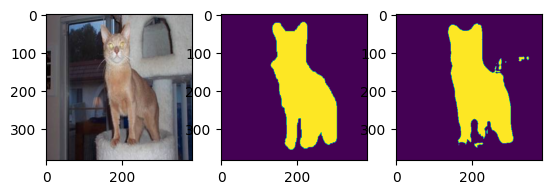

In [33]:
import random
model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x,y = test_dataset[idx]
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze()
    y_hat_mask = y_hat.sigmoid().round().long()
    plt.subplot(1,3,1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1,2,0))
    plt.subplot(1,3,2)
    plt.imshow(y)
    plt.subplot(1,3,3)
    plt.imshow(y_hat_mask.cpu())
    print(y_hat_mask.unique())